In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import math
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 500)
import statsmodels.api as sm
'''
What data do we want to scrap? 
FJ before and after totals
FJ Category
Previous champion total (prior, #number of games)


Show #, air date
game 3966, clue value doubled.



'''    


'\nWhat data do we want to scrap? \nFJ before and after totals\nFJ Category\nPrevious champion total (prior, #number of games)\n\n\nShow #, air date\ngame 3966, clue value doubled.\n\n\n\n'

In [300]:
import importlib
import bs4.BeautifulSoup
importlib.reload(BeautifulSoup)

ModuleNotFoundError: No module named 'bs4.BeautifulSoup'

In [98]:
	game_id=5416
	url = "http://www.j-archive.com/showgame.php?game_id="+str(game_id)
	response = requests.get(url)
	reg_num=re.compile(r'\d+')
	soup = BeautifulSoup(response.text, 'lxml')
	game_info={}
	game_info['game_id']=game_id

In [99]:
q=soup.find_all('h2')
q[-1].get_text()

'Tiebreaker Round'

In [21]:
def game_scraper(game_id):
	url = "http://www.j-archive.com/showgame.php?game_id="+str(game_id)
	response = requests.get(url)
	reg_num=re.compile(r'\d+')
	soup = BeautifulSoup(response.text, 'lxml')
	game_info={}
	game_info['game_id']=game_id




	#Parse to get show # and date
	game_title=soup.find_all('head')[0].find_all('title')[0].get_text()
	nums=reg_num.findall(game_title)
	try:game_info['game_num']=nums[0]
	except:return 0
	game_info['date']=datetime.date(year=int(nums[1]), month=int(nums[2]), day=int(nums[3]))


	# In[93]:

#8/23, added Battle of the Decades, need to rerun
	#Parse to get if tournament
	game_comment=soup.find_all('body')[0].find_all('div',id="game_comments")[0].get_text()
	if game_comment.find('Tournament of Champions')>=0:game_info['game_type']='champion'
	elif game_comment.find('Teachers Tournament')>=0:game_info['game_type']='teacher'
	elif game_comment.find('College Championship')>=0:game_info['game_type']='college'
	elif game_comment.find('Teen Tournament')>=0:game_info['game_type']='teen'
	elif game_comment.find('Power Players')>=0:game_info['game_type']='power'  
	elif game_comment.find('Celebrity')>=0:game_info['game_type']='celebrity'
	elif game_comment.find('Kids')>=0:game_info['game_type']='kids' 
	elif game_comment.find('The IBM Challenge')>=0:game_info['game_type']='watson' 
	elif game_comment.find('International Tournament')>=0:game_info['game_type']='international'  
	elif game_comment.find('Anniversary Tournament')>=0:game_info['game_type']='anniversary'
	elif game_comment.find('Super Jeopardy!')>=0:game_info['game_type']='super'
	elif game_comment.find('Battle of the Decades')>=0:game_info['game_type']='battle'
	elif game_comment.find('All-Star')>=0:game_info['game_type']='all_star'  
	else:game_info['game_type']='regular'
	try:
		if soup.find_all('h3')[4].get_text()=='Cumulative scores:':final_table_offset=1
		else: final_table_offset=0
	except:return 0
	if game_info['game_type']=='all_star':return 0
	try:
		if soup.find_all('h2')[-1].get_text()=='Tiebreaker Round':tie_break_offset=1
		else: tie_break_offset=0
	except:return 0

	try:q=soup.find_all('table')[-6-final_table_offset-tie_break_offset].find_all('td',class_=["score_positive","score_negative"])
	except: return 0

	i=0
	for qq in q:
		i+=1
		game_info['player '+str(i)+' pre FJ score']=qq.get_text().replace('$','').replace(',','')




	game_info['fj_category']=soup.find_all('table')[-4-final_table_offset-tie_break_offset].find_all('td',class_="category_name")[0].get_text()



	q=soup.find_all('table')[-2-final_table_offset].find_all('td',class_=["score_positive","score_negative"])
	i=0
	for qq in q:
		i+=1
		game_info['player '+str(i)+' final score']=qq.get_text().replace('$','').replace(',','')

    
	q=soup.find_all('table')[-1].find_all('td',class_="score_remarks")
	i=0


	for qq in q:
		i+=1
		x=qq.get_text().split(',')
		try:game_info['player '+str(i)+' Rs']=reg_num.findall(x[0].split('(')[0])[0] 
		except:game_info['player '+str(i)+' Rs']=0
		try:game_info['player '+str(i)+' R DDs']=reg_num.findall(x[0].split('(')[1])[0]  
		except:game_info['player '+str(i)+' R DDs']=0    
		try:game_info['player '+str(i)+' Ws']=reg_num.findall(x[1].split('(')[0])[0] 
		except:game_info['player '+str(i)+' Ws']=0
		try:game_info['player '+str(i)+' W DDs']=reg_num.findall(x[1].split('(')[1])[0]  
		except:game_info['player '+str(i)+' W DDs']=0         
            
	q=soup.find_all('table')[-1].find_all('td',class_="score_positive")
	i=0


	for qq in q:
		i+=1

		try:game_info['player '+str(i)+' Coryat']=q.get_text().replace('$','').replace(',','')
		except:game_info['player '+str(i)+' Coryat']=0

	q=soup.find_all('table')[0].find_all('p',class_="contestants")
	i=0
	for qq in q:
		i+=1
		x=qq.get_text().split('(')[0].split(',')
		game_info['player '+str(4-i)+' name']=x[0]
		game_info['player '+str(4-i)+' town']=x[1].split('from')[-1]
		game_info['player '+str(4-i)+' occupation']=x[1].split('from')[0][1:-1]
		game_info['player '+str(4-i)+' state']=x[-1]
	pattern=r'\d+-day'

	#Might want to add logic to capture tournament subtotals later
	if game_info['game_type']=='regular':
		regex=re.compile(pattern)
		x=regex.findall(q[2].get_text())

		try:
			game_info['previous_wins']=x[0][:x[0].find('-')]

			pattern=r'\$[\d|,]+\)'
			regex=re.compile(pattern)
			x=regex.findall(q[2].get_text())
			game_info['previous_total']=x[0][:-1].replace('$','').replace(',','')
		except:
			game_info['previous_wins']='missing'
			game_info['previous_total']='missing'
	else:
		game_info['previous_wins']='N/A'
		game_info['previous_total']='N/A'
	return game_info

In [22]:
game_out=game_scraper(6223)

In [23]:
import sys,os
sys.path.append(os.getcwd())

game_out=game_scraper(1)
game_frame=pd.DataFrame(game_out,index=[0])
for game_id in range(6223,6390): 
    game_out=game_scraper(game_id) 
    if game_out:game_frame=game_frame.append(game_out,ignore_index=True) 
    print(game_id) 
game_frame=game_frame.set_index('game_num') 
game_frame.drop_duplicates(inplace=True)
game_frame.to_csv('jeop_scrap_17_9_2019.csv')

6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389


In [105]:
#This is very slow, row by row iteration. Maybe fix someday?
first_run=1
for index, row in game_frame.iterrows():
    #print(row)
    if row['game_type']=='super':continue
    try:
        if math.isnan(int(row['player 3 pre FJ score'])):continue
    except:continue
    s=[int(row['player 1 pre FJ score']),int(row['player 2 pre FJ score']),int(row['player 3 pre FJ score'])]
    indices=np.argsort(s)

    old=['1','2','3']
    c=4
    #row_mod=row.copy()
    row_mod={}
    row_mod['date']=row['date']
    row_mod['fj_category']=row['fj_category']
    row_mod['game_id']=row['game_id']
    row_mod['game_type']=row['game_type']
    row_mod['previous_total']=row['previous_total']
    row_mod['previous_wins']=row['previous_wins']
    row_mod['game_num']=index
    for i in indices:
        c-=1
        row_mod['player '+str(c)+' name']=row['player '+old[i]+' name']
        row_mod['player '+str(c)+' R DDs']=int(row['player '+old[i]+' R DDs'])
        row_mod['player '+str(c)+' Rs']=int(row['player '+old[i]+' Rs'])
        row_mod['player '+str(c)+' W DDs']=int(row['player '+old[i]+' W DDs'])
        row_mod['player '+str(c)+' Ws']=row['player '+old[i]+' Ws']
        row_mod['player '+str(c)+' final score']=int(row['player '+old[i]+' final score'])
        row_mod['player '+str(c)+' occupation']=row['player '+old[i]+' occupation']
        row_mod['player '+str(c)+' pre FJ score']=int(row['player '+old[i]+' pre FJ score'])
        row_mod['player '+str(c)+' town']=row['player '+old[i]+' state']
        row_mod['player '+str(c)+' state']=row['player '+old[i]+' town']
        
        if row_mod['player '+str(c)+' pre FJ score']<row_mod['player '+str(c)+' final score']:
            row_mod['player '+str(c)+' FJ correct']=1
            row_mod['player '+str(c)+' wager']=row_mod['player '+str(c)+' final score']-row_mod['player '+str(c)+' pre FJ score']
        else:
            row_mod['player '+str(c)+' FJ correct']=0
            row_mod['player '+str(c)+' wager']=-row_mod['player '+str(c)+' final score']+row_mod['player '+str(c)+' pre FJ score']
            
    row_mod['previous champ']=i+1
    if  first_run:game_frame2=pd.DataFrame(row_mod,index=[0])
    else: game_frame2=game_frame2.append(row_mod,ignore_index=True) 
    first_run=0
game_frame2['P2/P1']=game_frame2['player 2 pre FJ score']/game_frame2['player 1 pre FJ score']
game_frame2['P3/P1']=game_frame2['player 3 pre FJ score']/game_frame2['player 1 pre FJ score']
game_frame2['P3/P2']=game_frame2['player 3 pre FJ score']/game_frame2['player 2 pre FJ score']
game_frame2['W1/P1']=game_frame2['player 1 wager']/game_frame2['player 1 pre FJ score']
game_frame2['W2/P2']=game_frame2['player 2 wager']/game_frame2['player 2 pre FJ score']
game_frame2['W3/P3']=game_frame2['player 3 wager']/game_frame2['player 3 pre FJ score']
game_frame2['P1']=game_frame2['player 1 pre FJ score']
game_frame2['P2']=game_frame2['player 2 pre FJ score']
game_frame2['P3']=game_frame2['player 3 pre FJ score']
game_frame2['W1']=game_frame2['player 1 wager']
game_frame2['W2']=game_frame2['player 2 wager']
game_frame2['W3']=game_frame2['player 3 wager']

game_frame2['F1']=game_frame2['player 1 final score']
game_frame2['F2']=game_frame2['player 2 final score']
game_frame2['F3']=game_frame2['player 3 final score']

game_frame2['fj_2bit']=(game_frame2['player 1 FJ correct'].astype('str')+
    game_frame2['player 2 FJ correct'].astype('str'))
game_frame2['fj_3bit']=(game_frame2['player 1 FJ correct'].astype('str')+
    game_frame2['player 2 FJ correct'].astype('str')+game_frame2['player 3 FJ correct'].astype('str'))

def region_finder(game):
    if game['W2']+game['P2']<game['P1']-game['W1']:return 'R4'
    #R1, 
    elif game['W2']+game['P2']>game['P1']+game['W1']:return 'R1'
    elif game['P2']-game['W2']>game['P1']-game['W1']:return 'R2'
    else:return 'R3'
game_frame2['region']=game_frame2.apply(region_finder,axis=1)

game_frame2['winning_total']=game_frame2[["player 1 final score", "player 2 final score","player 3 final score"]].max(axis=1)

p1_win_mask=(game_frame2['player 1 final score']>=game_frame2['player 2 final score'])&(game_frame2['player 1 final score']>=game_frame2['player 3 final score'])
p2_win_mask=(game_frame2['player 2 final score']>=game_frame2['player 1 final score'])&(game_frame2['player 2 final score']>=game_frame2['player 3 final score'])
p3_win_mask=(game_frame2['player 3 final score']>=game_frame2['player 2 final score'])&(game_frame2['player 3 final score']>=game_frame2['player 1 final score'])
game_frame2.loc[p1_win_mask,'Winner']='P1'
game_frame2.loc[p2_win_mask,'Winner']='P2'
game_frame2.loc[p3_win_mask,'Winner']='P3'

#Adjusting pre score doubling games to have right total. Note, 
for i in ['1','2','3']:
    game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'P'+i)] =2*game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'P'+i)] 
    game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'W'+i)] =2*game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'W'+i)] 
    game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'F'+i)] =2*game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'F'+i)] 
game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'winning_total')] =2*game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'winning_total')]
game_frame2['previous_total'].replace('N/A',0,inplace=True)
game_frame2['previous_total'].replace('missing',-1,inplace=True)

game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'previous_total')] =2*game_frame2.loc[(game_frame2['date']<pd.to_datetime('2001-11-26', infer_datetime_format=True),'previous_total')].astype('int32')


In [107]:
#What do we make the cut-off? NEed to adjust for clue values doubling after 2001-11-26

#Lose a lot of 1996-09-02
gf3=game_frame2.loc[(game_frame2['date']>pd.to_datetime('1997-09-01', infer_datetime_format=True)) & (game_frame2['game_type']=='regular')]

In [108]:
pickle.dump( gf3, open( "jeop_game_frame_9_23_19.p", "wb" ) )

In [2]:
#8/12
game_frame2=pickle.load(open( "jeop_game_frame_9_23_19.p", "rb" ))

In [18]:
game_frame2['date'].count()

4115

Text(0, 0.5, 'W1/P1')

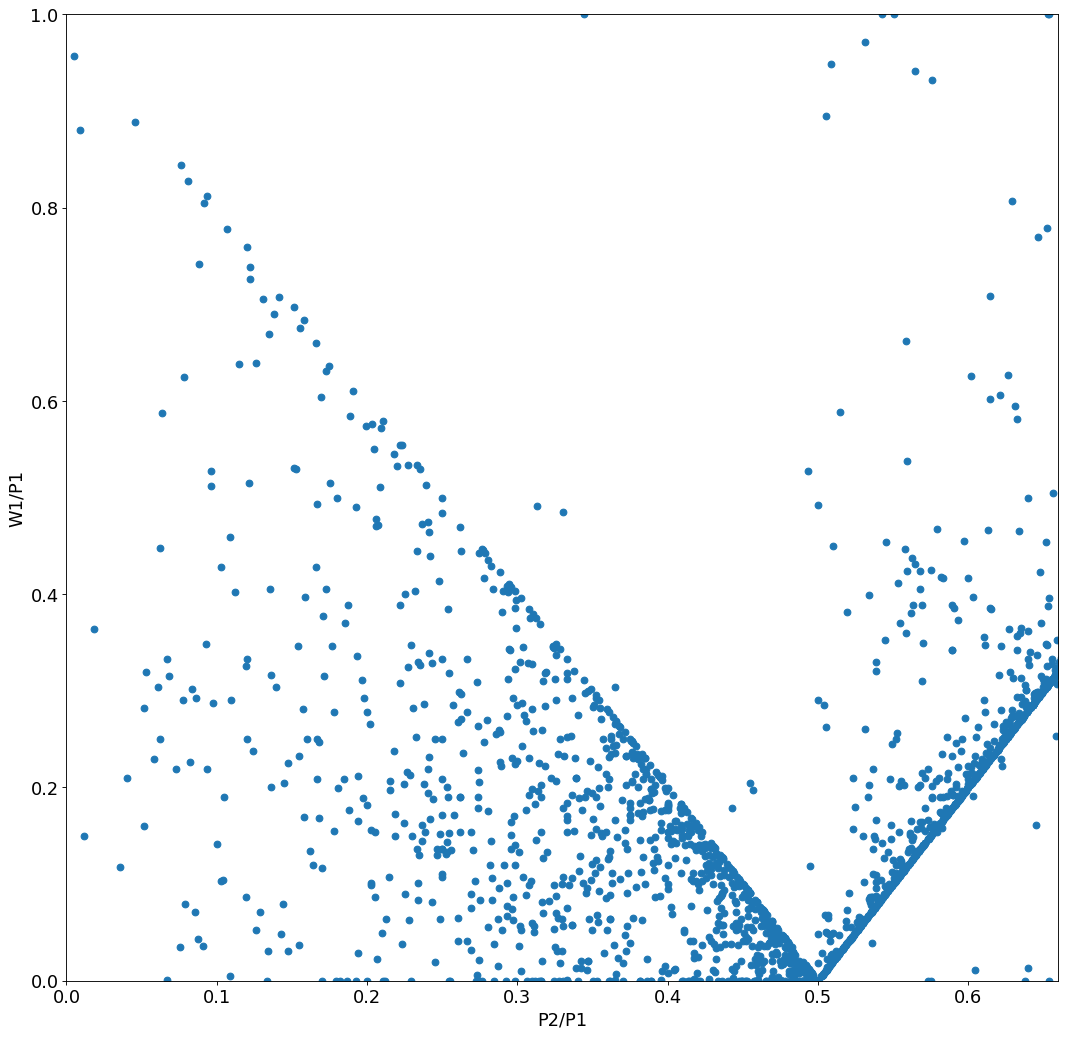

In [3]:
plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
plt.scatter(game_frame2['P2/P1'],game_frame2['W1/P1'])
plt.xlim(0,0.66)
plt.ylim(0,1)
plt.xlabel('P2/P1')
plt.ylabel('W1/P1')

Text(0, 0.5, 'W1/P1')

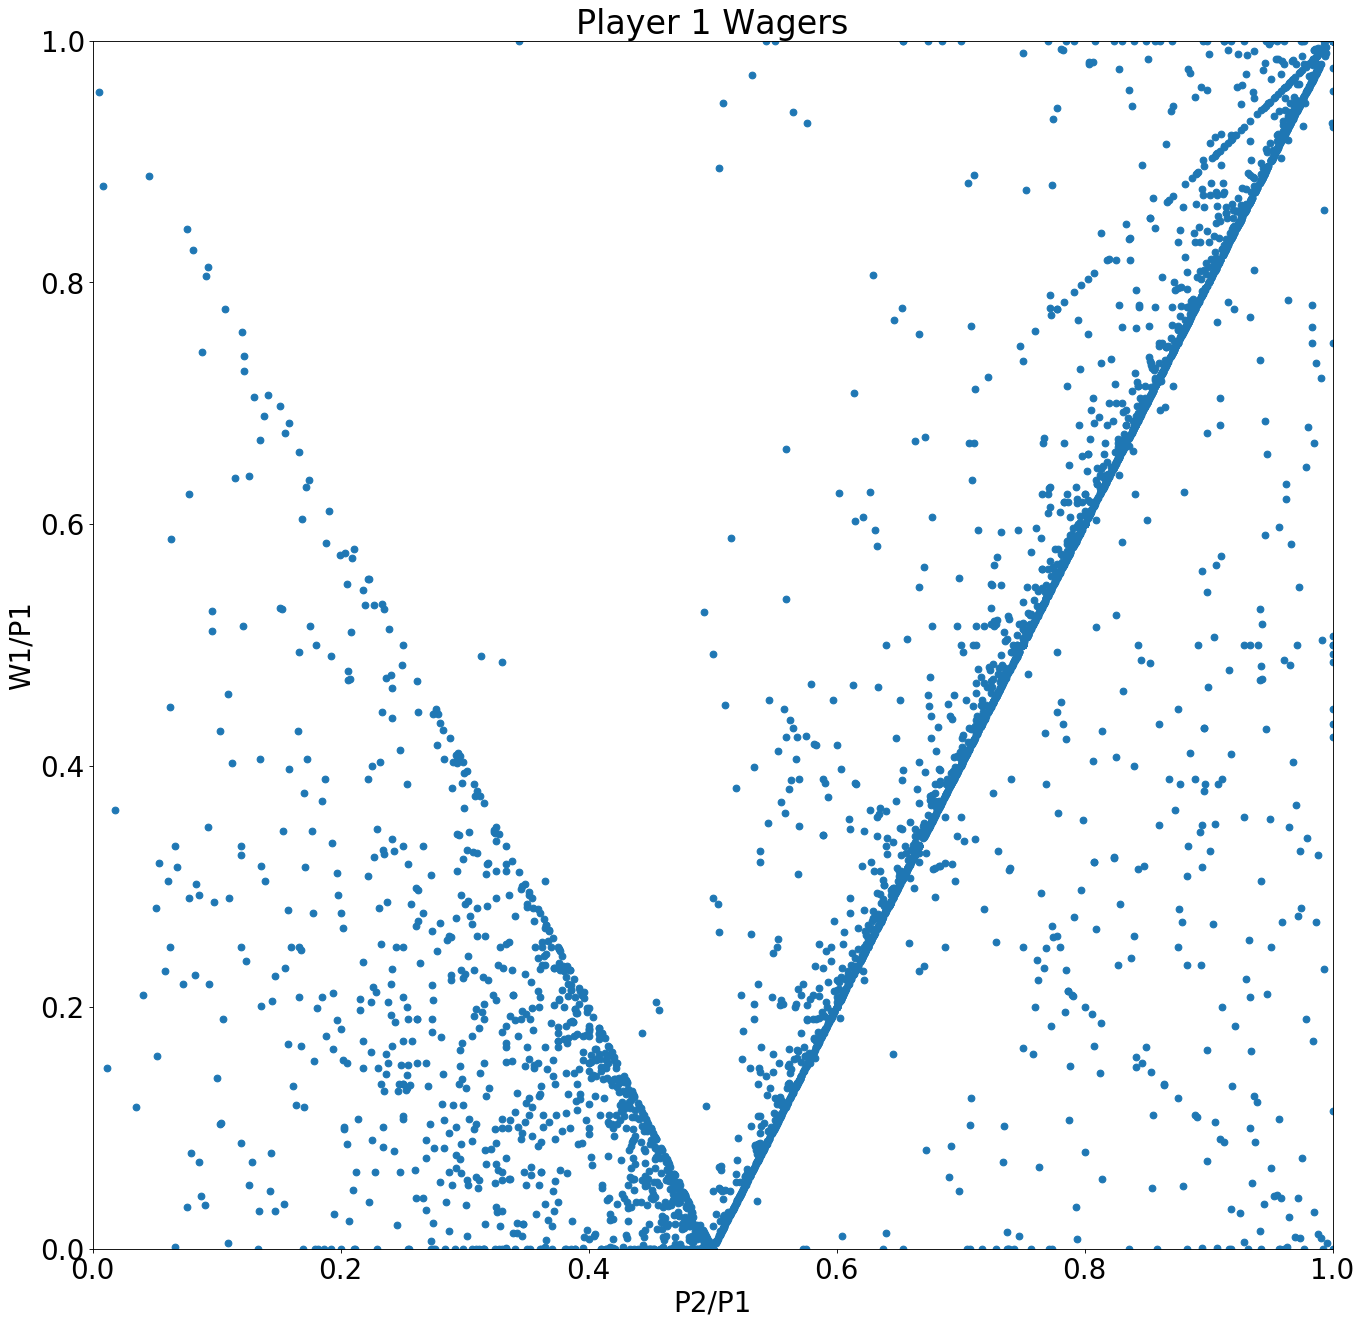

In [20]:

plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
plt.title('Player 1 Wagers')
plt.scatter(game_frame2.loc[game_frame2['game_type']=='regular','P2/P1'],game_frame2.loc[game_frame2['game_type']=='regular','W1/P1'])

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('P2/P1')
plt.ylabel('W1/P1')

Text(0, 0.5, 'W2/P2')

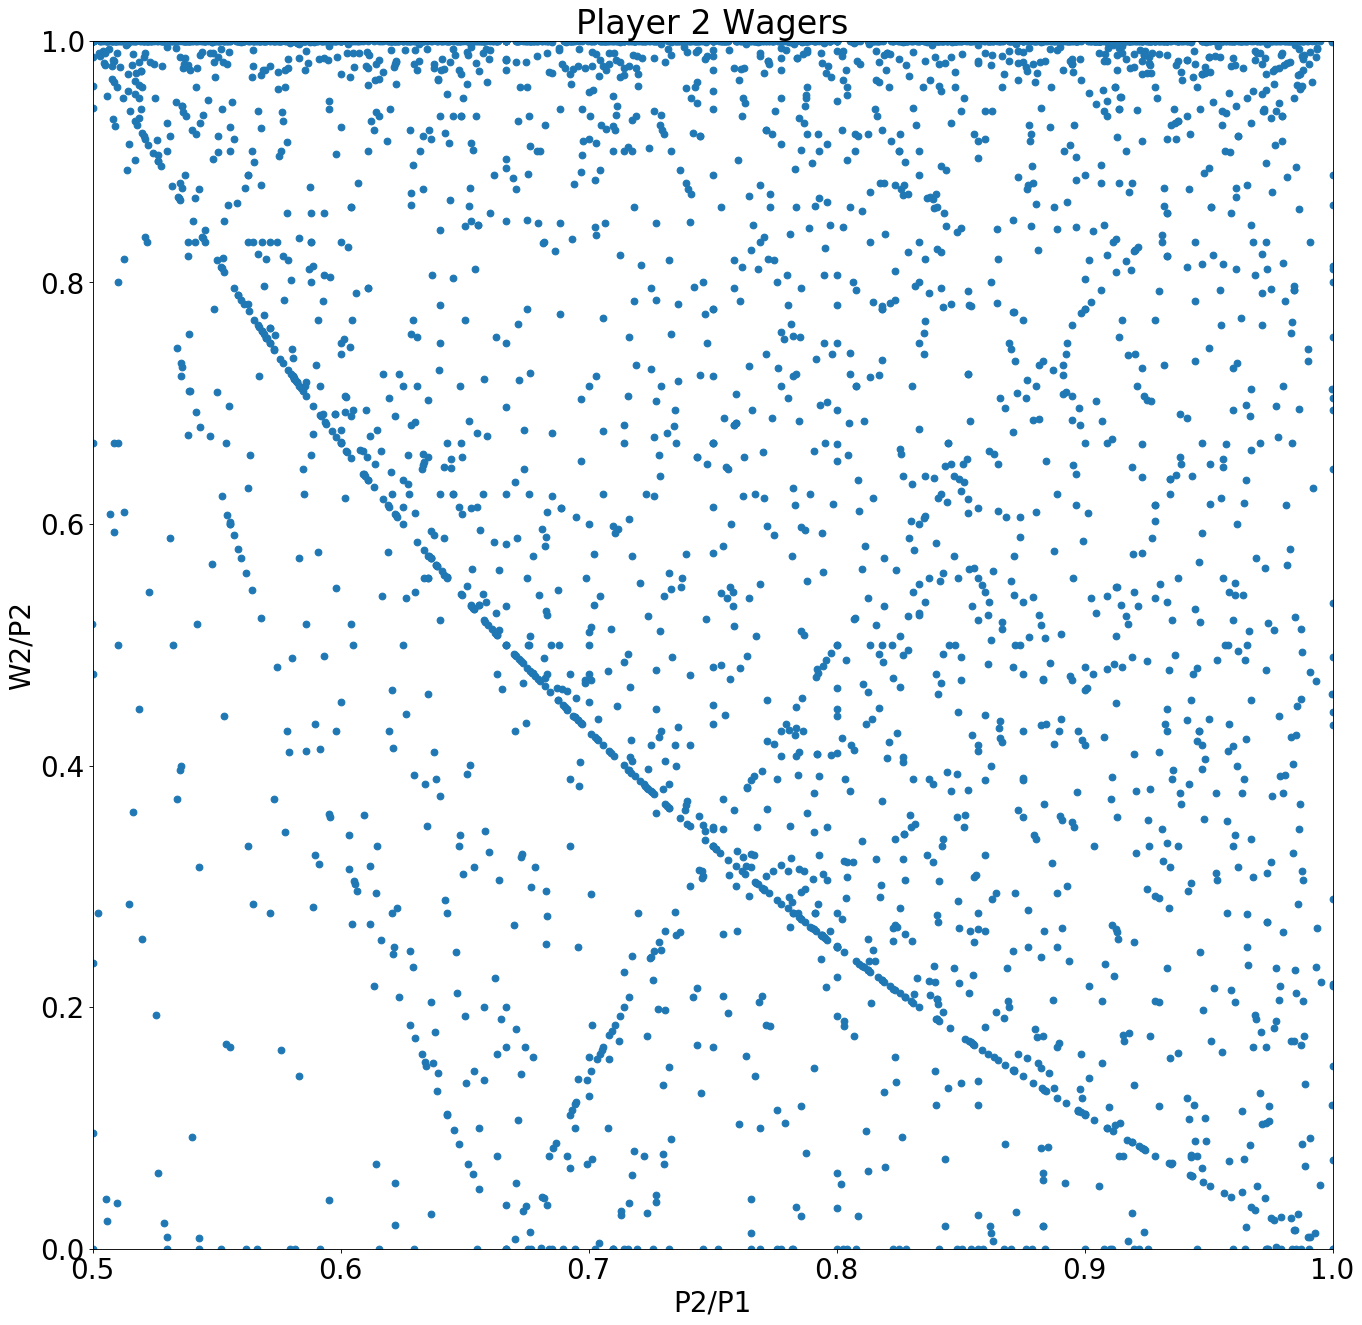

In [287]:
plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
#plt.title('Player 1 Wagers')
plt.title('Player 2 Wagers')
plt.scatter(game_frame2.loc[game_frame2['game_type']=='regular','P2/P1'],game_frame2.loc[game_frame2['game_type']=='regular','W2/P2'])
plt.xlim(0.5,1)
plt.ylim(0,1)
#game_frame2.plot.scatter('P2/P1','W2/P2')
plt.xlabel('P2/P1')
plt.ylabel('W2/P2')
#import matplotlib

In [113]:
cutoff=datetime.datetime(1996,8,15)
game_frame2[pd.to_datetime(game_frame2['date'],format=r'%Y-%d-%m',errors='ignore',infer_datetime_format=True)>cutoff]['game_type'].value_counts()

regular    4115
Name: game_type, dtype: int64

In [37]:
pd.to_datetime(game_frame2['date'][0],format='%Y-%d-%m')

Timestamp('2005-03-02 00:00:00')

In [36]:
game_frame2.loc[game_frame2['player 1 name']=='James Holzhauer']#['region'].value_counts()

,date,fj_category,game_id,game_type,previous_total,previous_wins,game_num,player 3 name,player 3 R DDs,player 3 Rs,player 3 W DDs,player 3 Ws,player 3 final score,player 3 occupation,player 3 pre FJ score,player 3 town,player 3 state,player 3 FJ correct,player 3 wager,player 2 name,player 2 R DDs,player 2 Rs,player 2 W DDs,player 2 Ws,player 2 final score,player 2 occupation,player 2 pre FJ score,player 2 town,player 2 state,player 2 FJ correct,player 2 wager,player 1 name,player 1 R DDs,player 1 Rs,player 1 W DDs,player 1 Ws,player 1 final score,player 1 occupation,player 1 pre FJ score,player 1 town,player 1 state,player 1 FJ correct,player 1 wager,previous champ,P2/P1,P3/P1,P3/P2,W1/P1,W2/P2,W3/P3,P1,P2,P3,W1,W2,W3,F1,F2,F3,fj_2bit,fj_3bit,region,winning_total,Winner
6168,2019-04-04,U.S. BODIES OF WATER,6256,regular,26000,1,7964,Anna Hautzinger,0,1,0,1,3200,a veterinarian,1600,Illinois,Chicago,1,1600,Alex Koral,1,25,0,2,20000,a regulatory research counsel,18000,Colorado,Boulder,1,2000,James Holzhauer,2,31,0,1,43680,a professional sports gambler,40412,Nevada,Las Vegas,1,3268,3,0.445412,0.039592,0.088889,0.080867,0.111111,1.000000,40412,18000,1600,3268,2000,1600,43680,20000,3200,11,111,R4,43680,P1
6169,2019-04-05,EUROPEAN CAPITALS,6257,regular,43680,1,7965,Marshall Shelburne,0,15,0,4,2445,a computer programmer,4000,California,Los Angeles,0,1555,Satish Chandrasekhar,2,18,0,1,12600,a medical student,18800,Florida,Jupiter,0,6200,James Holzhauer,1,22,0,1,38926,a professional sports gambler,29114,Nevada,Las Vegas,1,9812,1,0.645737,0.137391,0.212766,0.337020,0.329787,0.388750,29114,18800,4000,9812,6200,1555,38926,12600,2445,10,100,R3,38926,P1
6170,2019-04-08,HOLLYWOOD HISTORY,6258,regular,82606,2,7966,Maryanne Mowen,0,8,0,1,10000,an accounting professor,6000,New Mexico,Santa Fe,1,4000,Matthew Amster-Burton,1,17,0,1,12000,a podcast host,17600,Washington,Seattle,0,5600,James Holzhauer,2,30,0,1,50845,a professional sports gambler,43815,Nevada,Las Vegas,1,7030,1,0.401689,0.136939,0.340909,0.160447,0.318182,0.666667,43815,17600,6000,7030,5600,4000,50845,12000,10000,10,101,R4,50845,P1
6171,2019-04-09,PHYSICS TERMS,6259,regular,133451,3,7967,Ariana Mikulski,0,10,0,3,7100,an associate teaching professor,6400,Pennsylvania,State College,1,700,Sameer Rai,0,8,0,1,12801,a freelancer,7000,California,Los Altos,1,5801,James Holzhauer,3,42,0,1,110914,a professional sports gambler,72600,Nevada,Las Vegas,1,38314,1,0.096419,0.088154,0.914286,0.527741,0.828714,0.109375,72600,7000,6400,38314,5801,700,110914,12801,7100,11,111,R4,110914,P1
6172,2019-04-10,EUROPEAN HISTORY,6260,regular,244365,4,7968,Jeff Henderson,0,4,0,3,-600,a retail manager,-600,Canada,Calgary,0,0,Laura Hertzfeld,0,18,1,2,6800,a journalist,5800,California,Venice,1,1000,James Holzhauer,1,31,1,2,54322,a professional sports gambler,33200,Nevada,Las Vegas,1,21122,1,0.174699,-0.018072,-0.103448,0.636205,0.172414,-0.000000,33200,5800,-600,21122,1000,0,54322,6800,-600,11,110,R4,54322,P1
6173,2019-04-11,CELEBRITIES,6261,regular,298687,5,7969,Stephanie Stein,1,11,0,1,6300,an editor,11000,New York,Brooklyn,0,4700,Lewis Black,0,14,0,0,23000,an attorney,13000,Utah,Salt Lake City,1,10000,James Holzhauer,2,25,0,2,27190,a professional sports gambler,30200,Nevada,Las Vegas,0,3010,1,0.430464,0.364238,0.846154,0.099669,0.769231,0.427273,30200,13000,11000,3010,10000,4700,27190,23000,6300,01,010,R4,27190,P1
6174,2019-04-12,LITERARY ADAPTATIONS,6262,regular,325877,6,7970,Mike Dindoffer,0,12,0,2,7100,a writer and teacher,7400,Massachusetts,Greenfield,0,300,Ali Filipowicz,0,16,0,0,14801,a homemaker,13200,Virginia,Alexandria,1,1601,James Holzhauer,3,32,0,0,89158,a professional sports gambler,58148,Nevada,Las Vegas,1,31010,1,0.227007,0.127261,0.560606,0.533294,0.121288,0.040541,58148,13200,7400,31010,1601,300,89158,14801,7100,11,110,R4,89158,P1
6175,2019-04-15,STAMPS,6263,regular,415035,7,7971,Megan McLeod,0,5,0,2,1000,a cinema manager,4800,Canada,Ottawa,0,3800,Kevin Bohannon,0,15,0,1,12400,a cell biologist,124

In [34]:
game_frame2.loc[6216]

date                                        2019-06-03
fj_category                         SHAKESPEARE'S TIME
game_id                                           6304
game_type                                      regular
previous_total                                 2462216
previous_wins                                       32
game_num                                          8006
player 3 name                               Jay Sexton
player 3 R DDs                                       0
player 3 Rs                                         13
player 3 W DDs                                       0
player 3 Ws                                          1
player 3 final score                             17000
player 3 occupation         a senior research engineer
player 3 pre FJ score                            11000
player 3 town                                  Georgia
player 3 state                                 Atlanta
player 3 FJ correct                                  1
player 3 w

# Runaways and Near Runaways

In [4]:
runaway_mask=(game_frame2['game_type']=='regular')&(game_frame2['P2/P1']<0.5)
runaway_games=game_frame2.loc[runaway_mask]

near_runaway_mask=(game_frame2['game_type']=='regular')&(game_frame2['P2/P1']>0.5)&(game_frame2['P2/P1']<0.66)
near_runaway_games=game_frame2.loc[near_runaway_mask]

In [5]:
#max_wager=P1-2P2
runaway_games['wager_%']=runaway_games['W1']/(-runaway_games['P2']*2+runaway_games['P1'])*100

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
#Heuristics
x_nrw=np.linspace(0.5,0.6667,1000)
y_nrw_min=2*x_nrw-1
y_nrw_max=1-x_nrw
x_rw=np.linspace(0,0.5,100)
y_rw_max=1-2*x_rw

x_comp=np.linspace(0.6668,1,1000)
y_comp_p1_cover=1-x_comp
y_comp_p1_x=2*x_comp-1

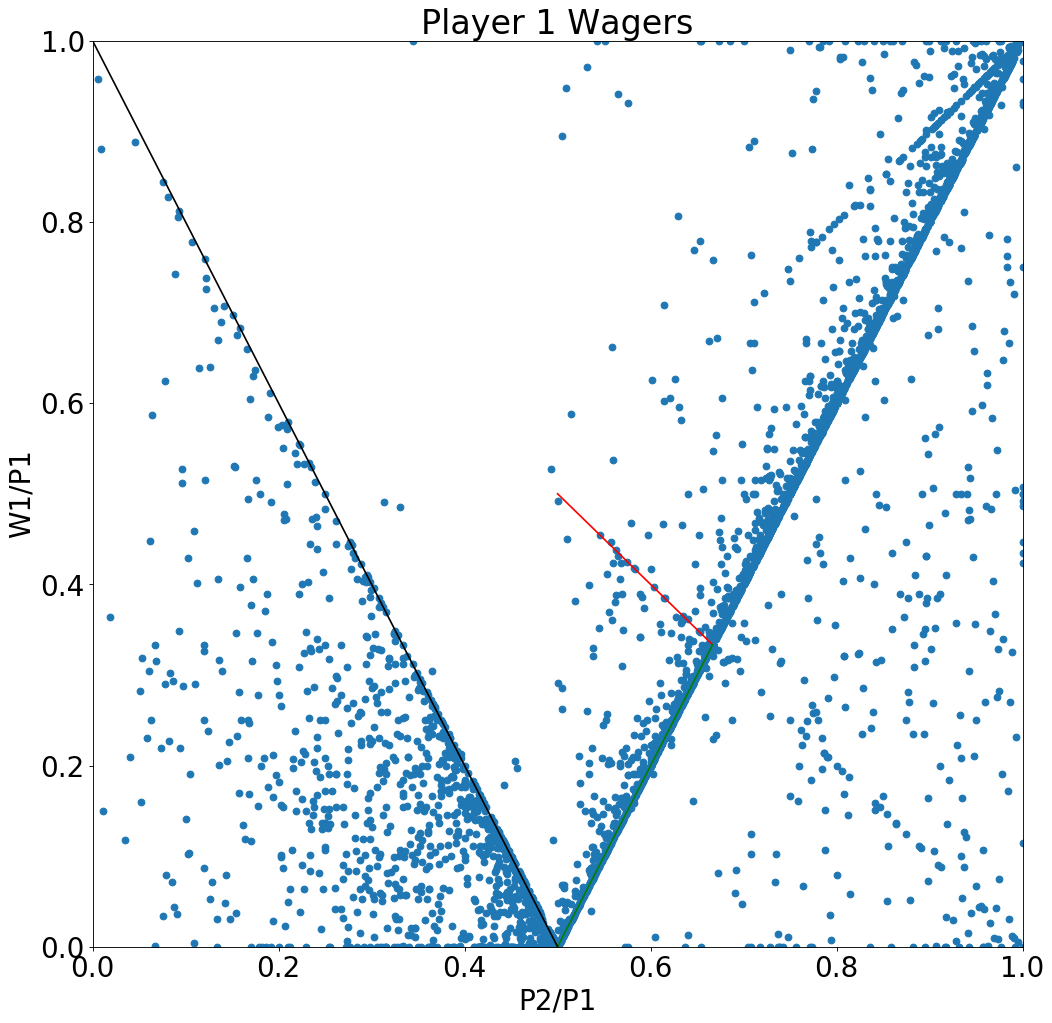

In [22]:
#Add all lines to this plot
plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
plt.title('Player 1 Wagers')
plt.scatter(game_frame2.loc[game_frame2['game_type']=='regular','P2/P1'],game_frame2.loc[game_frame2['game_type']=='regular','W1/P1'])

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('P2/P1')
plt.ylabel('W1/P1')

plt.plot(x_nrw,y_nrw_max,'r')
plt.plot(x_nrw,y_nrw_min,'g')
plt.plot(x_rw,y_rw_max,'k')

In [174]:
runaway_games.loc[(runaway_games['wager_%']<100)]['wager_%'].describe()

count    1265.000000
mean       53.875259
std        34.206355
min         0.000000
25%        25.000000
50%        54.794521
75%        87.500000
max        99.995370
Name: wager_%, dtype: float64

In [384]:
runaway_games['fj_2bit'].value_counts()/runaway_games.shape[0]*100

00    33.155488
10    26.295732
11    24.085366
01    16.463415
Name: fj_2bit, dtype: float64

In [388]:
near_runaway_games['fj_2bit'].value_counts()/near_runaway_games.shape[0]*100

00    29.179331
11    29.078014
10    22.391084
01    19.351570
Name: fj_2bit, dtype: float64

In [386]:
26.3+24.1-33.2-16.5

0.7000000000000028

In [390]:
1-0.194

0.806

In [160]:
#Want to calculate where they fell within their "safe" range
#min wager= 2P2-P1
#max_wager=P1-P2
near_runaway_games['wager_%']=(near_runaway_games['W1']-(2*near_runaway_games['P2']-near_runaway_games['P1']))/(
near_runaway_games['P1']-near_runaway_games['P2']-(2*near_runaway_games['P2']-near_runaway_games['P1']))*100

In [165]:
near_runaway_games.loc[(near_runaway_games['wager_%']<100)&(near_runaway_games['wager_%']>0)]['wager_%'].describe()

count    842.000000
mean      10.393292
std       22.453040
min        0.006098
25%        0.027778
50%        0.090909
75%        8.333333
max       99.980000
Name: wager_%, dtype: float64

In [381]:
near_runaway_games['fj_2bit'].value_counts()/near_runaway_games.shape[0]*100

00    29.179331
11    29.078014
10    22.391084
01    19.351570
Name: fj_2bit, dtype: float64

In [380]:
sum(runaway_games['wager_%']>100)/runaway_games.shape[0]*100

1.3719512195121952

In [246]:
sum(near_runaway_games['wager_%']>100)/near_runaway_games.shape[0]*100

5.673758865248227

In [247]:
sum(near_runaway_games['wager_%']<0)/near_runaway_games.shape[0]*100

2.43161094224924

In [250]:
sum(runaway_games['wager_%']>100)/runaway_games.shape[0]*100

1.3719512195121952

In [167]:
near_runaway_games.loc[(near_runaway_games['wager_%']<0)]['Winner'].value_counts()

P1    11
P2    10
P3     3
Name: Winner, dtype: int64

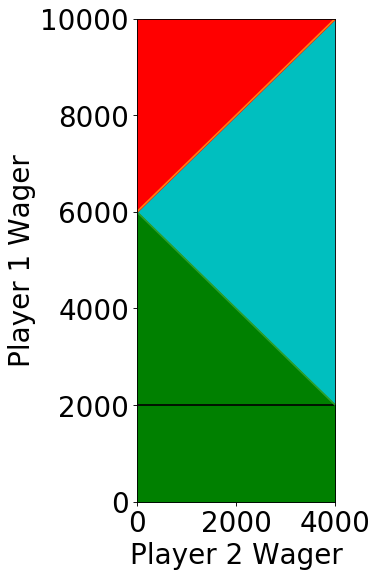

In [332]:
r_P1=10000
r_P2=4000
runaway_plot=plot_wager_space(r_P1,r_P2)
runaway_plot.hlines(y=(r_P1-2*r_P2),xmin=0,xmax=r_P2)


In [357]:
comp_plot.ylabel

AttributeError: 'AxesSubplot' object has no attribute 'ylabel'

Text(4000, 4000, 'R3')

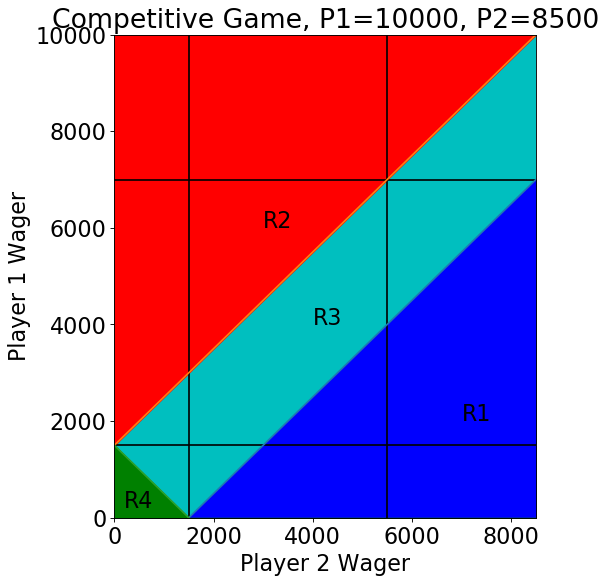

In [26]:
comp_P1=10000
comp_P2=8500
comp_plot=plot_wager_space(comp_P1,comp_P2)
#comp_plot.rcParams.update({'font.size': 25})
comp_plot.set_title('Competitive Game, P1='+str(comp_P1)+', P2='+str(comp_P2))
comp_plot.hlines(y=(comp_P1-comp_P2),xmin=0,xmax=comp_P2)
comp_plot.hlines(y=(-comp_P1+2*comp_P2),xmin=0,xmax=comp_P2)

comp_plot.vlines(x=(comp_P1-comp_P2),ymin=0,ymax=comp_P1)
#Reaction to P1 Covering
comp_plot.vlines(x=(-2*comp_P1+3*comp_P2),ymin=0,ymax=comp_P1)
#reaction to P1 small, not relevant enough to show?
#comp_plot.vlines(x=(2*comp_P1-2*comp_P2),ymin=0,ymax=comp_P1)
comp_plot.text(200,200,'R4')
comp_plot.text(7000,2000,'R1')
comp_plot.text(3000,6000,'R2')
comp_plot.text(4000,4000,'R3')

In [ ]:
double_runaway=runaway_games.loc[(game_frame2['game_type']=='regular')&(game_frame2['P3/P2']<0.5)]

In [371]:
double_runaway.shape

(596, 62)

In [31]:
plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
plt.scatter(double_runaway['P3/P2'],double_runaway['W2/P2'])
plt.xlim(0,0.5)
plt.ylim(0,1)
plt.xlabel('P3/P2')
plt.ylabel('W2/P2')

NameError: name 'double_runaway' is not defined

<Figure size 1280x1280 with 0 Axes>

In [ ]:
3*comp_games['P2']-2*comp_games['P1']

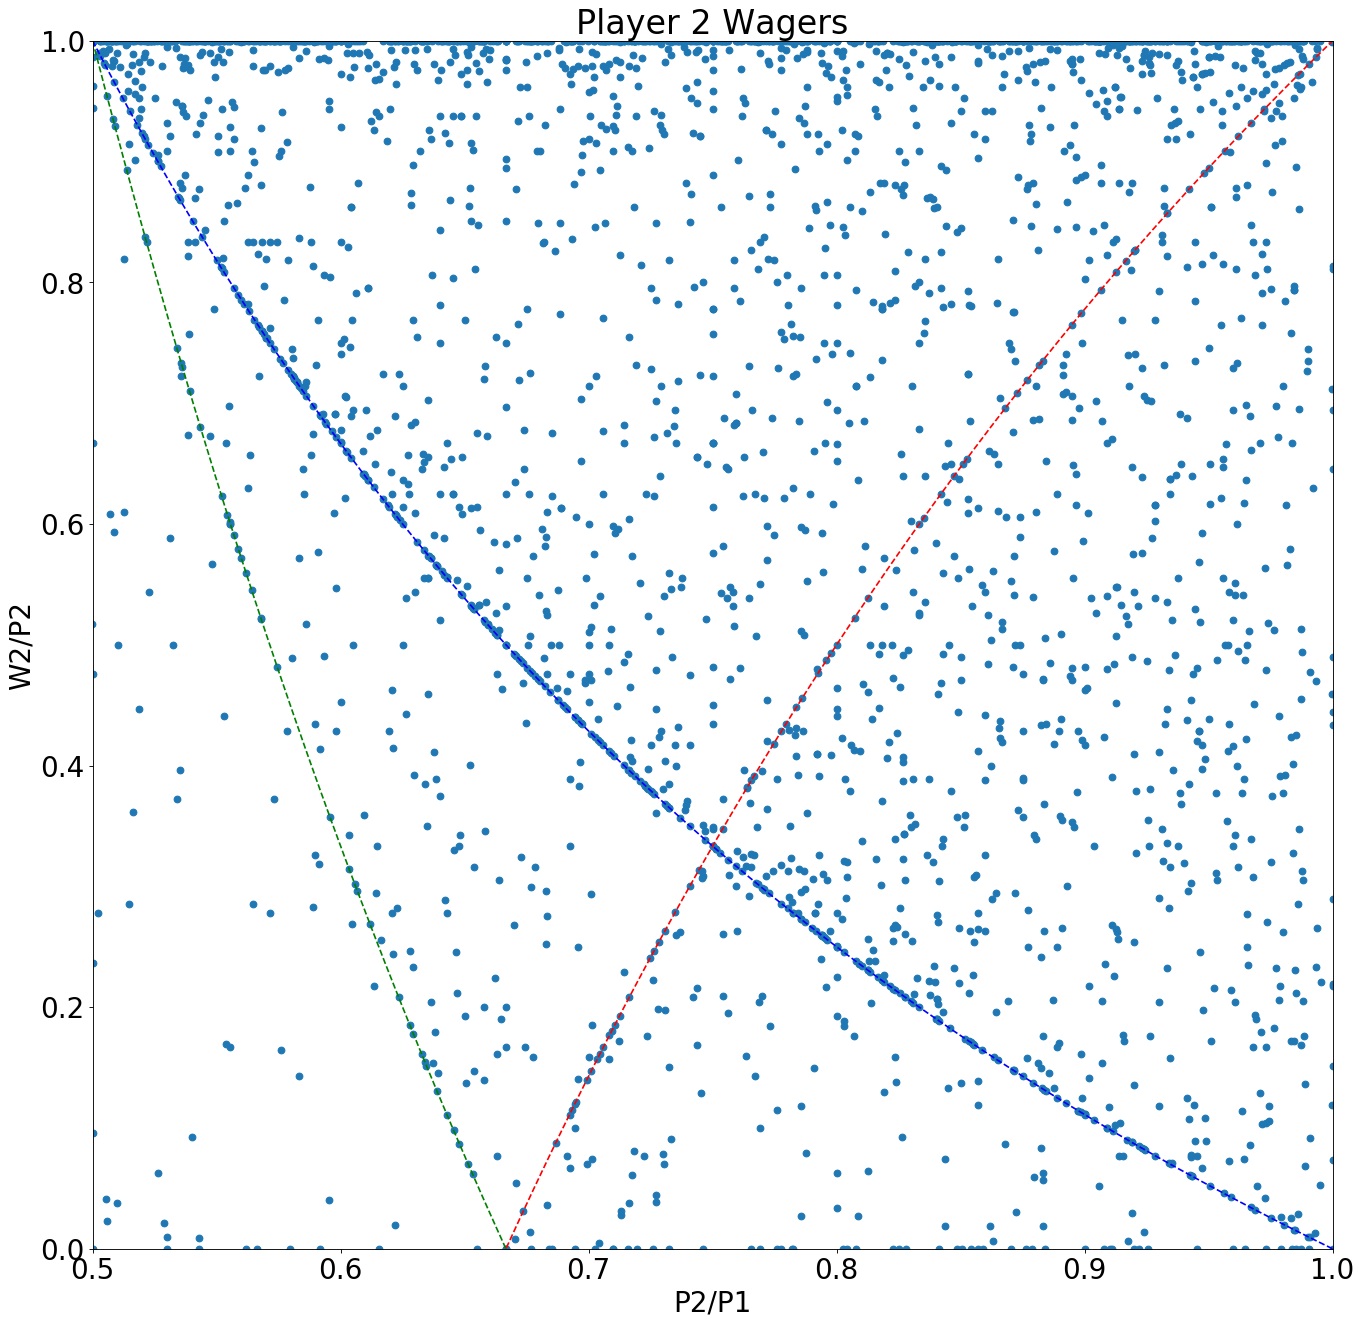

In [19]:

plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
#plt.title('Player 1 Wagers')
plt.title('Player 2 Wagers')
plt.scatter(game_frame2.loc[game_frame2['game_type']=='regular','P2/P1'],game_frame2.loc[game_frame2['game_type']=='regular','W2/P2'])
plt.xlim(0.5,1)
plt.ylim(0,1)
#game_frame2.plot.scatter('P2/P1','W2/P2')
plt.xlabel('P2/P1')
plt.ylabel('W2/P2')
#import matplotlib
plt.plot(x_nrw,nrw_min_w2,'g--')
plt.plot(x_nr_comp,w2_above_p1,'b--')
plt.plot(x_comp,w2_cover_react,'r--')
#plt.plot(x_comp,w2_unsure,'k--')

In [15]:
nr_P1=10000
nr_P2=6000
near_runaway_plot=plot_wager_space(nr_P1,nr_P2)
near_runaway_plot.hlines(y=(nr_P1-nr_P2),xmin=0,xmax=nr_P2)
near_runaway_plot.hlines(y=(-nr_P1+2*nr_P2),xmin=0,xmax=nr_P2)

near_runaway_plot.vlines(x=(2*nr_P1-3*nr_P2),ymin=0,ymax=nr_P1)

NameError: name 'plot_wager_space' is not defined

Text(0.5, 1.0, 'Runaways and Near Runaways')

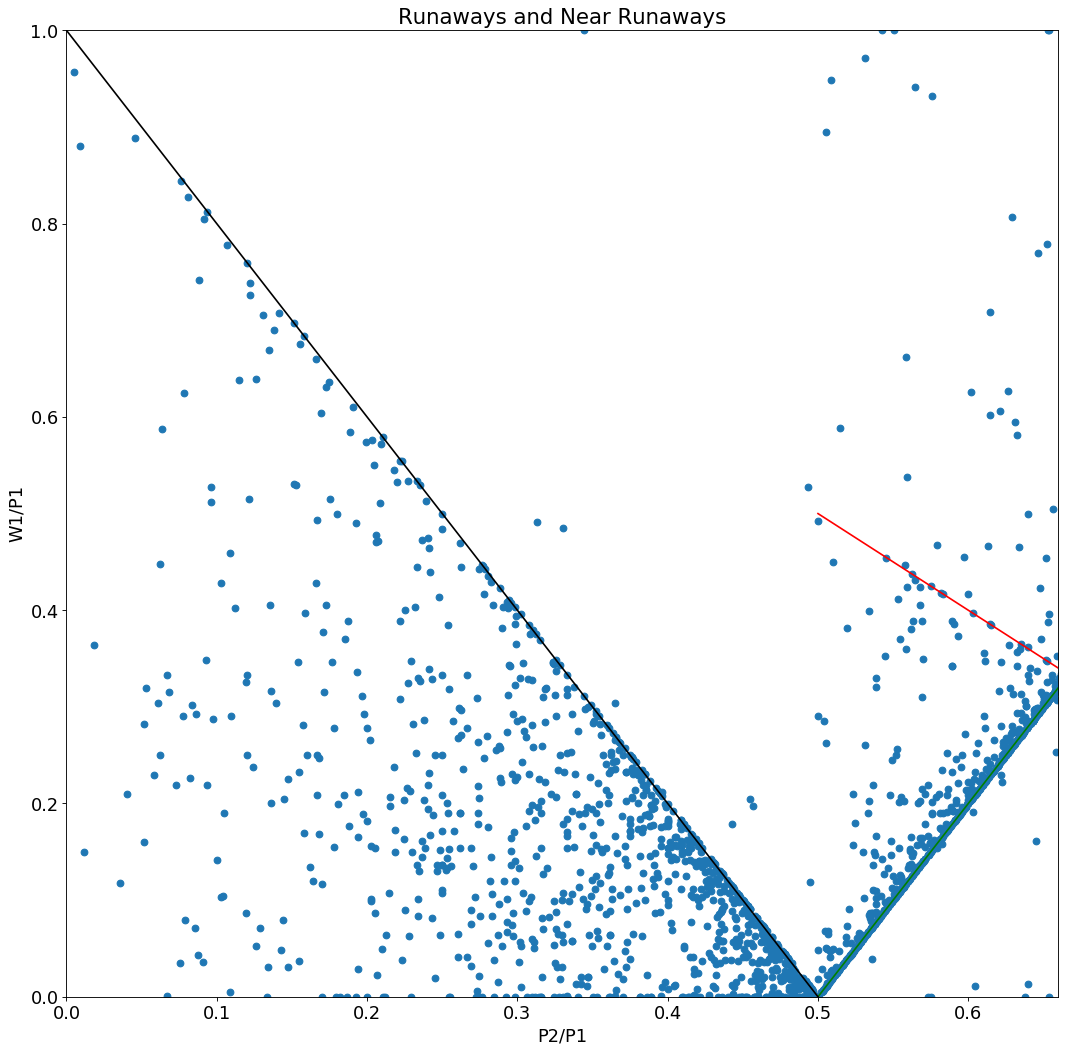

In [18]:
plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
plt.scatter(game_frame2['P2/P1'],game_frame2['W1/P1'])
plt.plot(x_nrw,y_nrw_max,'r')
plt.plot(x_nrw,y_nrw_min,'g')
plt.plot(x_rw,y_rw_max,'k')
plt.xlim(0,0.66)
plt.ylim(0,1)
plt.xlabel('P2/P1')
plt.ylabel('W1/P1')
plt.title('Runaways and Near Runaways')

In [252]:
runaway_games.head()

,date,fj_category,game_id,game_type,previous_total,previous_wins,game_num,player 3 name,player 3 R DDs,player 3 Rs,player 3 W DDs,player 3 Ws,player 3 final score,player 3 occupation,player 3 pre FJ score,player 3 town,player 3 state,player 3 FJ correct,player 3 wager,player 2 name,player 2 R DDs,player 2 Rs,player 2 W DDs,player 2 Ws,player 2 final score,player 2 occupation,player 2 pre FJ score,player 2 town,player 2 state,player 2 FJ correct,player 2 wager,player 1 name,player 1 R DDs,player 1 Rs,player 1 W DDs,player 1 Ws,player 1 final score,player 1 occupation,player 1 pre FJ score,player 1 town,player 1 state,player 1 FJ correct,player 1 wager,previous champ,P2/P1,P3/P1,P3/P2,W1/P1,W2/P2,W3/P3,Winner,fj_2bit,fj_3bit,P1,P2,P3,W1,W2,W3,region,wager_%
0,2004-09-06,COMIC BOOKS,1,regular,1321660,38,4596,Betsey Casman,0,4,0,2,1399,an appeal and grievance analyst,3200,Nevada,Las Vegas,0,1801,J.D. Smith,0,10,0,2,3599,an editor and writer,5000,D.C.,Washington,0,1401,Ken Jennings,2,38,1,3,10001,a software engineer,31600,Utah,Salt Lake City,0,21599,1,0.158228,0.101266,0.640000,0.683513,0.280200,0.562813,P1,00,000,31600,5000,3200,21599,1401,1801,R4,99.995370
1,2004-09-07,WAR MOVIES,2,regular,1331661,39,4597,Bob Watts,1,12,0,4,0,a poet,9600,North Carolina,Taylorsville,0,9600,Rich Hartz,1,13,0,1,19201,a food bank agency coordinator,10800,Alabama,Huntsville,1,8401,Ken Jennings,1,31,0,3,21800,a software engineer,28400,Utah,Salt Lake City,0,6600,1,0.380282,0.338028,0.888889,0.232394,0.777870,1.000000,P1,01,010,28400,10800,9600,6600,8401,9600,R4,97.058824
2,2004-09-08,HISTORIC MEDIUMS,3,regular,1353461,40,4598,Laura Gustafson,1,4,0,1,200,an information manager,3200,Massachusetts,Acton,0,3000,Adam Meyer,0,9,0,0,8800,a college professor,8800,Tennessee,Nashville,0,0,Ken Jennings,2,40,0,5,27200,a software engineer,33600,Utah,Salt Lake City,0,6400,1,0.261905,0.095238,0.363636,0.190476,0.000000,0.937500,P1,00,000,33600,8800,3200,6400,0,3000,R4,40.000000
3,2004-09-09,PRESIDENTS,4,regular,1380661,41,4599,Amy Helmes,0,6,0,1,5200,a writer originally,5200,Ohio,Cincinnati,0,0,Todd Perkins,0,9,0,0,8399,a private school administrator,9400,California,Vacaville,0,1001,Ken Jennings,1,42,2,5,21800,a software engineer,28400,Utah,Salt Lake City,0,6600,1,0.330986,0.183099,0.553191,0.232394,0.106489,0.000000,P1,00,000,28400,9400,5200,6600,1001,0,R4,68.750000
4,2004-09-10,PATRON SAINTS,5,regular,1402461,42,4600,Kollin Min,0,3,0,1,1,an attorney,2600,Washington,Seattle,0,2599,Bill Scheller,0,17,0,4,6000,a writer,6000,Vermont,Waterville,0,0,Ken Jennings,2,34,1,3,30000,a software engineer,28600,Utah,Salt Lake City,1,1400,1,0.209790,0.090909,0.433333,0.048951,0.000000,0.999615,P1,10,100,28600,6000,2600,1400,0,2599,R4,8.433735


In [267]:
runaway_games['ones']=1
logit_columns=['W1/P1','P1','player 1 Rs','ones']

In [70]:
comp_games.columns

Index(['date', 'fj_category', 'game_id', 'game_type', 'previous_total',
       'previous_wins', 'game_num', 'player 3 name', 'player 3 R DDs',
       'player 3 Rs', 'player 3 W DDs', 'player 3 Ws', 'player 3 final score',
       'player 3 occupation', 'player 3 pre FJ score', 'player 3 town',
       'player 3 state', 'player 3 FJ correct', 'player 3 wager',
       'player 2 name', 'player 2 R DDs', 'player 2 Rs', 'player 2 W DDs',
       'player 2 Ws', 'player 2 final score', 'player 2 occupation',
       'player 2 pre FJ score', 'player 2 town', 'player 2 state',
       'player 2 FJ correct', 'player 2 wager', 'player 1 name',
       'player 1 R DDs', 'player 1 Rs', 'player 1 W DDs', 'player 1 Ws',
       'player 1 final score', 'player 1 occupation', 'player 1 pre FJ score',
       'player 1 town', 'player 1 state', 'player 1 FJ correct',
       'player 1 wager', 'previous champ', 'P2/P1', 'P3/P1', 'P3/P2', 'W1/P1',
       'W2/P2', 'W3/P3', 'P1', 'P2', 'P3', 'W1', 'W2', 'W3', 'F1', '

In [94]:
comp_games['P1 Covers P2 bi']=comp_games['P1 Covers P2'].apply(lambda x: (1 if x else 0))
comp_games['W2 Large bi']=comp_games['W2 Large'].apply(lambda x: (1 if x else 0))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
#P1's wager not predictive of answering correctly in comp games
comp_games['ones']=1
logit_columns=['W2/P2','P2','player 2 Rs','ones']


logit = sm.Logit(comp_games['player 2 FJ correct'], comp_games[logit_columns])

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.672989
         Iterations 4


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     player 2 FJ correct   No. Observations:                  358
Model:                           Logit   Df Residuals:                      354
Method:                            MLE   Df Model:                            3
Date:                 Thu, 24 Oct 2019   Pseudo R-squ.:                 0.02889
Time:                         15:47:26   Log-Likelihood:                -240.93
converged:                        True   LL-Null:                       -248.10
Covariance Type:             nonrobust   LLR p-value:                  0.002486
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
W2/P2           1.1276      0.334      3.373      0.001       0.472       1.783
P2           6.613e-05    3.6e-05      1.835      0.066   -4.49e-06       0.000
player 2 Rs    -0.0108      0.035     -0.309      0.758      -0.079       0.058
ones           -1.3693      0.615     -2.225      0.026      -2.575      -0.163
===============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     player 2 FJ correct   No. Observations:                  358
Model:                           Logit   Df Residuals:                      354
Method:                            MLE   Df Model:                            3
Date:                 Thu, 24 Oct 2019   Pseudo R-squ.:                 0.02889
Time:                         15:39:06   Log-Likelihood:                -240.93
converged:                        True   LL-Null:                       -248.10
Covariance Type:             nonrobust   LLR p-value:                  0.002486
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
W2/P2           1.1276      0.334      3.373      0.001       0.472       1.783
P2           6.613e-05    3.6e-05      1.835      0.066   -4.49e-06       0.000
player 2 Rs    -0.0108      0.035     -0.309      0.758      -0.079       0.058
ones           -1.3693      0.615     -2.225      0.026      -2.575      -0.163
===============================================================================
"""

In [268]:


logit = sm.Logit(runaway_games['player 1 FJ correct'], runaway_games[logit_columns])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.681492
         Iterations 4


In [269]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     player 1 FJ correct   No. Observations:                 1312
Model:                           Logit   Df Residuals:                     1308
Method:                            MLE   Df Model:                            3
Date:                 Mon, 02 Sep 2019   Pseudo R-squ.:                 0.01677
Time:                         13:14:07   Log-Likelihood:                -894.12
converged:                        True   LL-Null:                       -909.37
Covariance Type:             nonrobust   LLR p-value:                 1.080e-06
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
W1/P1           1.8929      0.396      4.784      0.000       1.117       2.668
P1           1.057e-05   8.31e-06      1.272      0.203   -5.72e-06    2.69e-05
player 1 Rs     0.0073      0.013      0.571      0.568      -0.018       0.032
ones           -0.6549      0.274     -2.392      0.017      -1.191      -0.118
===============================================================================
"""

In [262]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     player 1 FJ correct   No. Observations:                 1312
Model:                           Logit   Df Residuals:                     1309
Method:                            MLE   Df Model:                            2
Date:                 Fri, 30 Aug 2019   Pseudo R-squ.:                 0.01360
Time:                         16:07:38   Log-Likelihood:                -897.00
converged:                        True   LL-Null:                       -909.37
Covariance Type:             nonrobust   LLR p-value:                 4.246e-06
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
W1/P1           1.8388      0.394      4.671      0.000       1.067       2.610
P1           1.217e-05   8.26e-06      1.472      0.141   -4.03e-06    2.84e-05
player 1 Rs    -0.0184      0.007     -2.688      0.007      -0.032      -0.005
===============================================================================
"""

## Look at competitive games

In [3]:
#comp_mask=(game_frame2['game_type']=='regular')&(game_frame2['P2/P1']>0.66)&(game_frame2['P2/P1']-game_frame2['P3/P1']>0.5)
comp_mask=(game_frame2['game_type']=='regular')&(game_frame2['P2/P1']>0.66)&(game_frame2['P2/P1']+game_frame2['P3/P1']<1)
#That second condition is derived from p1-(2p2-p1)<2p3, meaning p1 will still be above p3 no matter what.
comp_games=game_frame2.loc[comp_mask]
comp_games['P1 Covers P2']=1>2*comp_games['P2/P1']-comp_games['W1/P1']
comp_games['W2 Large']=comp_games['W2']>3*comp_games['P2']-2*comp_games['P1']

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
sum(game_frame2['game_type']=='regular')

4115

In [16]:
#MAking the W2 curves
x_nrw=np.linspace(0.5,0.6667,1000)
nrw_min_w2=2/x_nrw-3

x_nr_comp=np.linspace(0.5,1,1000)
w2_above_p1=1/x_nr_comp-1

x_comp=np.linspace(0.6668,1,1000)

w2_cover_react=-2/x_comp+3
#Small React, doesn't seem like its used often enough to include
w2_unsure=2/x_comp-2

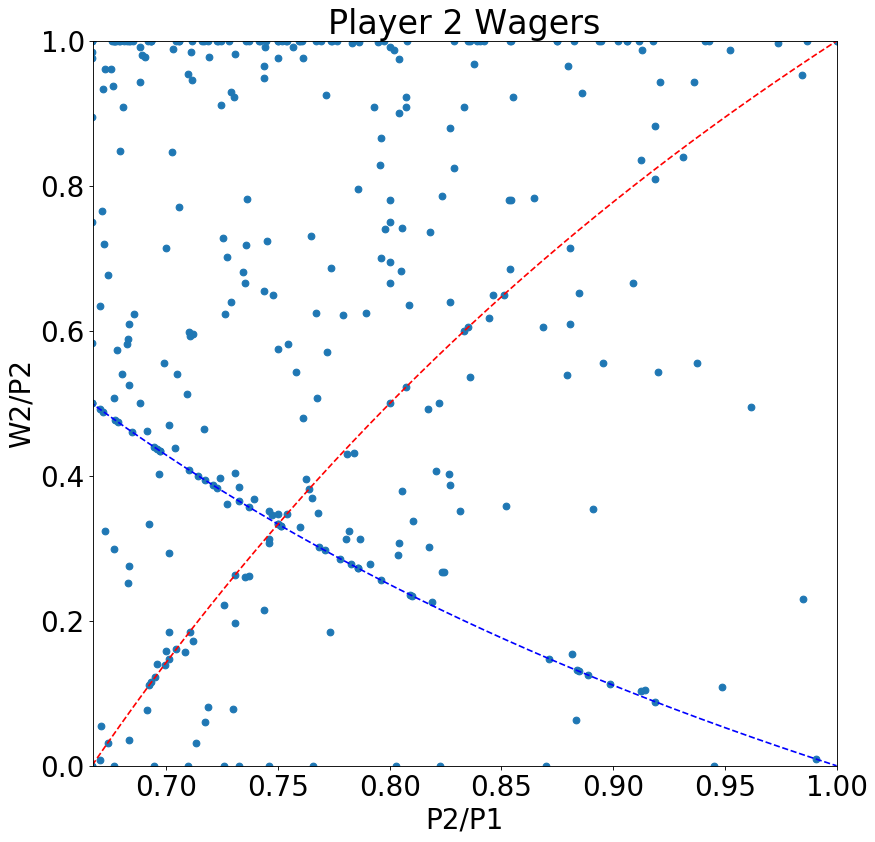

In [12]:

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
#plt.title('Player 1 Wagers')
plt.title('Player 2 Wagers')
plt.scatter(comp_games['P2/P1'],comp_games['W2/P2'])
plt.xlim(0.667,1)
plt.ylim(0,1)
#game_frame2.plot.scatter('P2/P1','W2/P2')
plt.xlabel('P2/P1')
plt.ylabel('W2/P2')
#import matplotlib
plt.plot(x_nrw,nrw_min_w2,'g--')
plt.plot(x_nr_comp,w2_above_p1,'b--')
plt.plot(x_comp,w2_cover_react,'r--')
#plt.plot(x_comp,w2_unsure,'k--')

In [60]:
x_comp=np.linspace(0.6668,1,1000)
y_comp_p1_cover=1-x_comp
y_comp_p1_x=2*x_comp-1

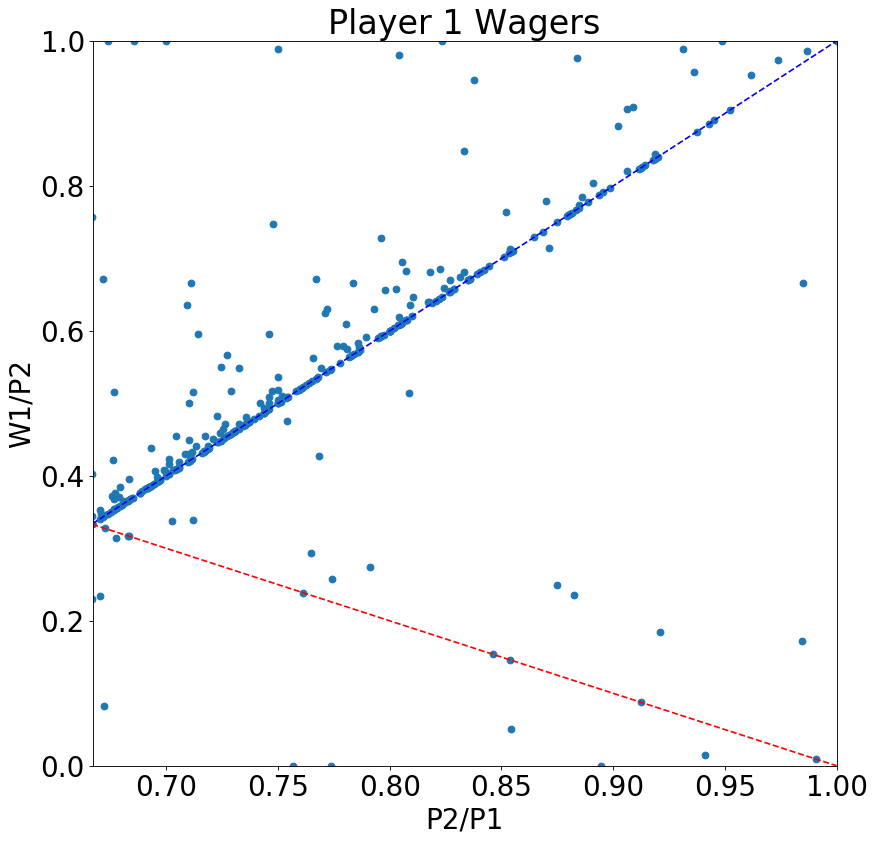

In [61]:

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
plt.title('Player 1 Wagers')
plt.scatter(comp_games['P2/P1'],comp_games['W1/P1'])
plt.xlim(0.667,1)
plt.ylim(0,1)
#game_frame2.plot.scatter('P2/P1','W2/P2')
plt.xlabel('P2/P1')
plt.ylabel('W1/P2')
#import matplotlib
#plt.plot(x_nrw,nrw_min_w2,'g--')
#plt.plot(x_nr_comp,w2_above_p1,'b--')
plt.plot(x_comp,y_comp_p1_cover,'r--')
plt.plot(x_comp,y_comp_p1_x,'b--')

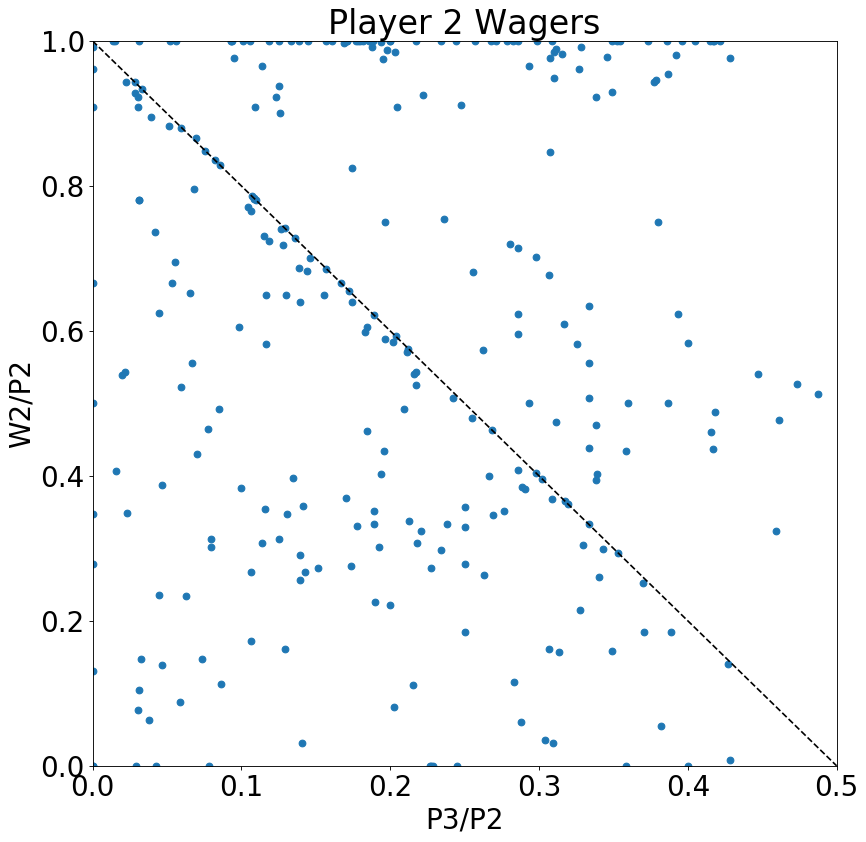

In [67]:

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})
#plt.title('Player 1 Wagers')
plt.title('Player 2 Wagers')
plt.scatter(comp_games['P3/P2'],comp_games['W2/P2'])
plt.xlim(0,0.5)
plt.ylim(0,1)
#game_frame2.plot.scatter('P2/P1','W2/P2')
plt.xlabel('P3/P2')
plt.ylabel('W2/P2')
#import matplotlib
#plt.plot(x_nrw,nrw_min_w2,'g--')
#plt.plot(x_nr_comp,w2_above_p1,'b--')
#plt.plot(x_comp,w2_cover_react,'r--')
plt.plot(x_rw,y_rw_max,'k--')

In [68]:
#3327, 5868
comp_games.sort_values('P3/P2')

,date,fj_category,game_id,game_type,previous_total,previous_wins,game_num,player 3 name,player 3 R DDs,player 3 Rs,player 3 W DDs,player 3 Ws,player 3 final score,player 3 occupation,player 3 pre FJ score,player 3 town,player 3 state,player 3 FJ correct,player 3 wager,player 2 name,player 2 R DDs,player 2 Rs,player 2 W DDs,player 2 Ws,player 2 final score,player 2 occupation,player 2 pre FJ score,player 2 town,player 2 state,player 2 FJ correct,player 2 wager,player 1 name,player 1 R DDs,player 1 Rs,player 1 W DDs,player 1 Ws,player 1 final score,player 1 occupation,player 1 pre FJ score,player 1 town,player 1 state,player 1 FJ correct,player 1 wager,previous champ,P2/P1,P3/P1,P3/P2,W1/P1,W2/P2,W3/P3,P1,P2,P3,W1,W2,W3,F1,F2,F3,fj_2bit,fj_3bit,region,winning_total,Winner,P1 Covers P2,W2 Large
5895,2018-04-25,GEOGRAPHY,5965,regular,20000,1,7748,Krishna Veeraraghavan,1,15,1,9,-4200,a sales analyst,-4200,Washington,Seattle,0,0,Jen Regan,0,10,0,1,14780,a travel marketer,7400,New Jersey,North Bergen,1,7380,Randy Mathews,0,16,1,6,199,a fragrance specialist,7600,Texas,Houston,0,7401,1,0.973684,-0.552632,-0.567568,0.973816,0.997297,-0.000000,7600,7400,-4200,7401,7380,0,199,14780,-4200,01,010,R3,14780,P2,True,True
4616,2003-10-28,LEGENDARY RULERS,4670,regular,17200,1,4402,Sara Uehlein,0,10,0,8,-4000,a law librarian,-4000,Virginia,Alexandria,0,0,Gary Conley,0,10,0,2,15900,a controller,8000,Ohio,Reynoldsburg,1,7900,John Lindquist,1,22,1,6,16001,an attorney,8400,Georgia,Marietta,1,7601,1,0.952381,-0.476190,-0.500000,0.904881,0.987500,-0.000000,8400,8000,-4000,7601,7900,0,16001,15900,-4000,11,110,R3,16001,P1,True,True
1445,2002-06-14,COLLEGE FOOTBALL,1468,regular,80800,3,4110,Marisa Griffin,0,8,0,5,-3800,an agricultural researcher,-3800,Georgia,Griffin,0,0,Rich Rosenlof,0,17,2,4,3800,a sales representative,7800,California,Sacramento,0,4000,Brian O'Riordan,0,22,1,6,18000,an audio/visual manager,11000,California,San Diego,1,7000,3,0.709091,-0.345455,-0.487179,0.636364,0.512821,-0.000000,11000,7800,-3800,7000,4000,0,18000,3800,-3800,10,100,R3,18000,P1,True,True
3512,2011-01-21,MOVIE SEQUELS,3557,regular,19201,1,6070,Sandy Hollimon,0,7,2,8,-3600,a college instructor of anthropology,-3600,California,Jenner,0,0,Amanda Sonmor,0,12,0,2,12300,a virtual assistant originally,7600,Colorado,Denver,1,4700,Scott Harris,0,22,1,4,2799,a videographer and elementary school librarian,9000,Nevada,Las Vegas,0,6201,1,0.844444,-0.400000,-0.473684,0.689000,0.618421,-0.000000,9000,7600,-3600,6201,4700,0,2799,12300,-3600,01,010,R2,12300,P2,True,False
561,2005-10-14,HISTORIC PEOPLE,563,regular,-1,missing,4850,Veronica Fazio,0,10,0,7,-1200,,-1200,Illinois,Roselle,0,0,Emily Zhang,1,14,2,6,0,,2800,Indiana,Indianapolis,0,2800,Aman Birk,0,14,0,7,4000,,3200,California,Irvine,1,800,1,0.875000,-0.375000,-0.428571,0.250000,1.000000,-0.000000,3200,2800,-1200,800,2800,0,4000,0,-1200,10,100,R1,4000,P1,False,True
2225,2008-01-04,U.S. PRESIDENTS,2268,regular,126101,6,5370,Heather Chapman,0,5,1,10,-6200,a news assistant,-6200,Kentucky,Lexington,0,0,Martin Truong,1,20,0,5,2,a printing consultant,14800,California,Fresno,0,14798,Dan Pawson,1,23,0,1,200,a legislative aide,15000,Massachusetts,Boston,0,14800,1,0.986667,-0.413333,-0.418919,0.986667,0.999865,-0.000000,15000,14800,-6200,14800,14798,0,200,2,-6200,00,000,R3,200,P1,True,True
4662,2014-11-03,SCIENTISTS,4716,regular,56800,3,6931,Ryan Alley,0,13,1,7,-2400,a patent attorney,-2400,Virginia,Alexandria,0,0,Casey LaPlante,0,10,1,5,5000,a high school media specialist,6500,Connecticut,Enfield,0,1500,Conor Sullivan,0,10,1,4,2200,a Jesuit volunteer and gym teacher,6600,Massachusetts,Hingham,0,4400,2,0.984848,-0.363636,-0.369231,0.666667,0.230769,-0.000000,6600,6500,-2400,4400,1500,0,2200,5000,-2400,00,000,R2,5000,P2,False,False
5420,2016-12-26,MOONS & PLANETS,5488,regular,56201,3,7431,Wren Allen,0,14,0,8,-2200,a botanical artist,-2200,New Mexico,Santa Fe,0,0,Sam Scovill,2,19,0,5,13200,a G.I.S. technician,6600,Oklahoma,Oklahoma City,1,6600,

In [43]:
comp_games.loc[comp_games['Winner']=='P3']

,date,fj_category,game_id,game_type,previous_total,previous_wins,game_num,player 3 name,player 3 R DDs,player 3 Rs,player 3 W DDs,player 3 Ws,player 3 final score,player 3 occupation,player 3 pre FJ score,player 3 town,player 3 state,player 3 FJ correct,player 3 wager,player 2 name,player 2 R DDs,player 2 Rs,player 2 W DDs,player 2 Ws,player 2 final score,player 2 occupation,player 2 pre FJ score,player 2 town,player 2 state,player 2 FJ correct,player 2 wager,player 1 name,player 1 R DDs,player 1 Rs,player 1 W DDs,player 1 Ws,player 1 final score,player 1 occupation,player 1 pre FJ score,player 1 town,player 1 state,player 1 FJ correct,player 1 wager,previous champ,P2/P1,P3/P1,P3/P2,W1/P1,W2/P2,W3/P3,P1,P2,P3,W1,W2,W3,F1,F2,F3,fj_2bit,fj_3bit,region,winning_total,Winner,P1 Covers P2,W2 Large
1703,2002-04-05,AUTHORS,1737,regular,53400,2,4060,Carol Schlau,0,10,0,2,9599,a newspaper copy editor,4800,New York,Buffalo,1,4799,Manoj Mate,2,16,0,2,4602,an attorney,12200,California,San Francisco,0,7598,Bill Alston,1,19,0,1,0,an accountant,17800,North Carolina,Durham,0,17800,1,0.685393,0.269663,0.393443,1.000000,0.622787,0.999792,17800,12200,4800,17800,7598,4799,0,4602,9599,00,001,R2,9599,P3,True,True
2870,2002-12-10,THE SPACE PROGRAM,2913,regular,32200,2,4207,Lee Weber,0,9,0,5,3200,a consultant,1600,Georgia,Atlanta,1,1600,Laura Dickinson,0,16,1,3,200,an associate professor,8200,Maryland,Laurel,0,8000,Ayesha Black,0,16,2,3,200,a student,10200,California,Los Angeles,0,10000,1,0.803922,0.156863,0.195122,0.980392,0.975610,1.000000,10200,8200,1600,10000,8000,1600,200,200,3200,00,001,R3,3200,P3,True,True


In [44]:
comp_games['region'].value_counts()/comp_games.shape[0]

R3    0.631285
R2    0.315642
R1    0.050279
R4    0.002793
Name: region, dtype: float64

In [38]:
comp_games['region'].value_counts()

247

In [27]:
sum(game_frame2['game_type']=='regular')

5043

358

In [10]:
comp_games['fj_2bit'].value_counts()/comp_games.shape[0]

11    0.357542
00    0.284916
10    0.223464
01    0.134078
Name: fj_2bit, dtype: float64

In [13]:
#pr(P1c|P2c)=Pr(P1c&P2c)/Pr(P2c)
0.357542/(0.357542+0.134078)

0.7272730971075221

In [39]:
sum(comp_games['P1 Covers P2'])/comp_games.shape[0]

0.8770949720670391

In [425]:
sum(comp_games['W2 Large'])/comp_games.shape[0]

0.698876404494382

In [44]:
large_p2_mask=comp_games['player 2 wager']>3*comp_games['player 2 pre FJ score']-2*comp_games['player 1 pre FJ score']

In [47]:
comp_games.loc[large_p2_mask].shape[0]/comp_games.shape[0]

0.7018779342723005

In [53]:
comp_games['fj_2bit'].value_counts()/comp_games.shape[0]*100

11    35.211268
00    28.169014
10    21.830986
01    14.788732
Name: fj_2bit, dtype: float64

In [30]:
comp_games['Winner'].value_counts()/comp_games.shape[0]*100


P1    73.611111
P2    25.277778
P3     0.555556
Name: Winner, dtype: float64

In [53]:
#pickle.dump( game_frame2, open( "jeop_game_frame2.p", "wb" ) )

In [190]:
game_frame2.head()

,date,fj_category,game_id,game_type,previous_total,previous_wins,game_num,player 3 name,player 3 R DDs,player 3 Rs,player 3 W DDs,player 3 Ws,player 3 final score,player 3 occupation,player 3 pre FJ score,player 3 town,player 3 state,player 3 FJ correct,player 3 wager,player 2 name,player 2 R DDs,player 2 Rs,player 2 W DDs,player 2 Ws,player 2 final score,player 2 occupation,player 2 pre FJ score,player 2 town,player 2 state,player 2 FJ correct,player 2 wager,player 1 name,player 1 R DDs,player 1 Rs,player 1 W DDs,player 1 Ws,player 1 final score,player 1 occupation,player 1 pre FJ score,player 1 town,player 1 state,player 1 FJ correct,player 1 wager,previous champ,P2/P1,P3/P1,P3/P2,W1/P1,W2/P2,W3/P3,Winner,fj_2bit,fj_3bit,P1,P2,P3,W1,W2,W3,region
0,2004-09-06,COMIC BOOKS,1,regular,1321660,38,4596,Betsey Casman,0,4,0,2,1399,an appeal and grievance analyst,3200,Nevada,Las Vegas,0,1801,J.D. Smith,0,10,0,2,3599,an editor and writer,5000,D.C.,Washington,0,1401,Ken Jennings,2,38,1,3,10001,a software engineer,31600,Utah,Salt Lake City,0,21599,1,0.158228,0.101266,0.640000,0.683513,0.280200,0.562813,P1,00,000,31600,5000,3200,21599,1401,1801,R4
1,2004-09-07,WAR MOVIES,2,regular,1331661,39,4597,Bob Watts,1,12,0,4,0,a poet,9600,North Carolina,Taylorsville,0,9600,Rich Hartz,1,13,0,1,19201,a food bank agency coordinator,10800,Alabama,Huntsville,1,8401,Ken Jennings,1,31,0,3,21800,a software engineer,28400,Utah,Salt Lake City,0,6600,1,0.380282,0.338028,0.888889,0.232394,0.777870,1.000000,P1,01,010,28400,10800,9600,6600,8401,9600,R4
2,2004-09-08,HISTORIC MEDIUMS,3,regular,1353461,40,4598,Laura Gustafson,1,4,0,1,200,an information manager,3200,Massachusetts,Acton,0,3000,Adam Meyer,0,9,0,0,8800,a college professor,8800,Tennessee,Nashville,0,0,Ken Jennings,2,40,0,5,27200,a software engineer,33600,Utah,Salt Lake City,0,6400,1,0.261905,0.095238,0.363636,0.190476,0.000000,0.937500,P1,00,000,33600,8800,3200,6400,0,3000,R4
3,2004-09-09,PRESIDENTS,4,regular,1380661,41,4599,Amy Helmes,0,6,0,1,5200,a writer originally,5200,Ohio,Cincinnati,0,0,Todd Perkins,0,9,0,0,8399,a private school administrator,9400,California,Vacaville,0,1001,Ken Jennings,1,42,2,5,21800,a software engineer,28400,Utah,Salt Lake City,0,6600,1,0.330986,0.183099,0.553191,0.232394,0.106489,0.000000,P1,00,000,28400,9400,5200,6600,1001,0,R4
4,2004-09-10,PATRON SAINTS,5,regular,1402461,42,4600,Kollin Min,0,3,0,1,1,an attorney,2600,Washington,Seattle,0,2599,Bill Scheller,0,17,0,4,6000,a writer,6000,Vermont,Waterville,0,0,Ken Jennings,2,34,1,3,30000,a software engineer,28600,Utah,Salt Lake City,1,1400,1,0.209790,0.090909,0.433333,0.048951,0.000000,0.999615,P1,10,100,28600,6000,2600,1400,0,2599,R4


In [23]:
# Standard plotly imports
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)

init_notebook_mode(connected=True)

In [29]:
cg_p1x=comp_games.set_index('P2/P1')

In [31]:
all_games_pl1x=game_frame2.set_index('P2/P1')

In [52]:

all_games_pl1x.iplot(y='W1/P1',mode='markers',color='LightSkyBlue',size=10)
# fig.update_traces(marker=dict(size=12,color='LightSkyBlue',
#                               line=dict(width=2,
#                                         color='DarkSlateGrey')))

In [50]:
all_games_pl1x.iplot(y='W1/P1',mode='markers')

SyntaxError: invalid syntax (<ipython-input-50-9d39d5929dc8>, line 1)

In [53]:
#comp_mask=(game_frame2['game_type']=='regular')&(game_frame2['P2/P1']>0.66)&(game_frame2['P2/P1']-game_frame2['P3/P1']>0.5)
middle_mask=(game_frame2['game_type']=='regular')&(game_frame2['P2/P1']>0.5)&(game_frame2['P2/P1']<0.66)
#That second condition is derived from p1-(2p2-p1)<2p3, meaning p1 will still be above p3 no matter what.
middle_games=game_frame2.loc[middle_mask]

In [71]:
middle_games.head(5)

,date,fj_category,game_id,game_type,previous_total,previous_wins,game_num,player 3 name,player 3 R DDs,player 3 Rs,player 3 W DDs,player 3 Ws,player 3 final score,player 3 occupation,player 3 pre FJ score,player 3 town,player 3 state,player 3 FJ correct,player 3 wager,player 2 name,player 2 R DDs,player 2 Rs,player 2 W DDs,player 2 Ws,player 2 final score,player 2 occupation,player 2 pre FJ score,player 2 town,player 2 state,player 2 FJ correct,player 2 wager,player 1 name,player 1 R DDs,player 1 Rs,player 1 W DDs,player 1 Ws,player 1 final score,player 1 occupation,player 1 pre FJ score,player 1 town,player 1 state,player 1 FJ correct,player 1 wager,previous champ,P2/P1,P3/P1,P3/P2,W1/P1,W2/P2,W3/P3,Winner,fj_2bit,fj_3bit
36,2004-10-26,AUTHORS,37,regular,2006300,59,4632,Mary Carpenter,0,5,1,5,-2400,an engineer,-2400,Delaware,Bear,0,0,Jeff Matthews,0,14,0,3,5500,a managing copy editor,10800,California,Los Angeles,0,5300,Ken Jennings,2,25,0,5,25000,a software engineer,18200,Utah,Salt Lake City,1,6800,1,0.593407,-0.131868,-0.222222,0.373626,0.490741,-0.000000,P1,10,100
44,2004-11-06,SPORTS,45,regular,2272600,67,4640,Leo Wolpert,0,4,0,2,1,a college student,200,Virginia,Fairfax,0,199,Ryan Cook,0,21,0,2,29100,a graduate student originally,16600,Minnesota,Eveleth,1,12500,Ken Jennings,2,31,1,2,33201,a software engineer,27600,Utah,Salt Lake City,1,5601,1,0.601449,0.007246,0.012048,0.202935,0.753012,0.995000,P1,11,110
63,2004-12-02,VOCABULARY,64,regular,13400,1,4659,Sherri Benoun,0,15,2,6,1,a planning clerk,5600,California,Anaheim,0,5599,Josh Kolchins,1,16,0,4,400,a homeland security consultant,8400,Maryland,Bethesda,0,8000,Katie Fitzgerald,0,21,0,1,16801,a wealth management project analyst originally,16000,New York,New Rochelle,1,801,1,0.525000,0.350000,0.666667,0.050063,0.952381,0.999821,P1,10,100
65,2004-12-06,CHILDREN'S STORIES,66,regular,16200,1,4661,Pete DeBalli,0,14,0,3,100,an anesthesiologist,9000,Florida,Titusville,0,8900,Dennis Grace,1,19,0,3,25000,an engineer,13400,Michigan,West Bloomfield,1,11600,Andy Zimdars,2,26,0,4,21199,a graduate student,24000,California,Menlo Park,0,2801,3,0.558333,0.375000,0.671642,0.116708,0.865672,0.988889,P2,01,010
67,2004-12-08,THE CABINET,68,regular,8700,1,4663,Jackie Cipa,0,8,0,5,0,a library assistant,1400,Pennsylvania,Pittsburgh,0,1400,Alex Bready,1,20,0,3,12800,a law student,12800,Maryland,Towson,0,0,Megan Susman,2,19,0,1,19599,an environmental policy specialist,22600,Virginia,Arlington,0,3001,3,0.566372,0.061947,0.109375,0.132788,0.000000,1.000000,P1,00,000


In [55]:
mg_p1x=middle_games.set_index('P2/P1')
mg_p1x.iplot(y='W1/P1',mode='markers',color='LightSkyBlue',size=10)

# Region Plotting

In [ ]:
L1:W1=W2-(P1-P2), L2:W1=(P1-P2)+W2, and L3:W1=(P1-P2)-W1

In [24]:
def plot_wager_space(P1,P2):
    W2=np.linspace(0,P2,100)
    L1=W2-(P1-P2)
    L2=(P1-P2)+W2
    L3=(P1-P2)-W2
    scale=8
    plt.figure(figsize=(scale*P2/P1, scale), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 20})
    plt.plot(W2,L1)
    plt.plot(W2,L2)
    plt.plot(W2,L3)
    # plt.scatter(game_frame2['P2/P1'],game_frame2['W1/P1'])
    plt.xlim(0,P2)
    plt.ylim(0,P1)
    #R3
    plt.fill_between(W2,L2,P1,color='r')
    #R1
    plt.fill_between(W2,L1,0,color='b')
    #R4
    plt.fill_between(W2,L3,0,color='g')
    #R2, hacky, just changing background color. Easier than trying to figure out how to fill between multiple lines (probably would have done it in two sections)
    ax = plt.gca()
    
    ax.set_facecolor('c')
    plt.xlabel('Player 2 Wager')
    plt.ylabel('Player 1 Wager')
    return ax

# Nash Equilibria

In [ ]:
w1,W1,w2,W2

In [21]:
comp_correct_probs=comp_games['fj_2bit'].value_counts()/comp_games.shape[0]
P00=comp_correct_probs['00']
P01=comp_correct_probs['01']
P10=comp_correct_probs['10']
P11=comp_correct_probs['11']
P1X=P10+P11
PX0=P10+P00

In [178]:
game_frame2['fj_2bit'].value_counts()/game_frame2.shape[0]*100

00    29.796251
11    29.013855
10    21.678892
01    19.511002
Name: fj_2bit, dtype: float64

In [ ]:
P1
R1:P00*(P1-W1+V)+P10*(P1+W1+V)+(P01+P11)*RU
R2:P11*(P1+W1+V)+P10*(P1+W1+V)+(P01+P00)*RU
R3:P00* (P1-W1+V)+ P1X*(P1+W1+V)+P01*RU 

P2:    
R1:P11*(P2+W2+V)+P01*(P2+W2+V)+(P00+P10)*RU
R2:P00*(P2-W2+V)+P01*(P2+W2+V)+(P10+P11)*RU
R3:P01* (P2+W2+V)+ (P11+PX0)*RU

    


In [307]:
P1_POM

[[54692.13483146067, 32256.1797752809], [40814.05393258427, 55860.96629213483]]

In [22]:
#Check that the NE at a range of P2/P1s
P1=13000
P2=10000
W1=7001
w1=3000
W2=9900
w2=3001
RU=2000

V=50000
#small r3
ssP1=P00* (P1-w1+V)+ P1X*(P1+w1+V)+P01*RU 
ssP2=P01* (P2+w2+V)+ (P11+PX0)*RU
#big r3
bbP1=P00* (P1-W1+V)+ P1X*(P1+W1+V)+P01*RU 
bbP2=P01* (P2+W2+V)+ (P11+PX0)*RU
#R1
sbP1=P00*(P1-w1+V)+P10*(P1+w1+V)+(P01+P11)*RU
sbP2=P11*(P2+W2+V)+P01*(P2+W2+V)+(P00+P10)*RU
#R2
bsP1=P11*(P1+W1+V)+P10*(P1+W1+V)+(P01+P00)*RU
bsP2=P00*(P2-w2+V)+P01*(P2+w2+V)+(P10+P11)*RU
P1_POM=[[ssP1,sbP1],[bsP1,bbP1]]
P2_POM=[[ssP2,sbP2],[bsP2,bbP2]]

In [51]:
#Check that the NE at a range of P2/P1s
P1=0
P2=0
W1=0
w1=0
W2=0
w2=0
RU=0

V=1
#small r3
ssP1=P00* (P1-w1+V)+ P1X*(P1+w1+V)+P01*RU 
ssP2=P01* (P2+w2+V)+ (P11+PX0)*RU
#big r3
bbP1=P00* (P1-W1+V)+ P1X*(P1+W1+V)+P01*RU 
bbP2=P01* (P2+W2+V)+ (P11+PX0)*RU
#R1
sbP1=P00*(P1-w1+V)+P10*(P1+w1+V)+(P01+P11)*RU
sbP2=P11*(P2+W2+V)+P01*(P2+W2+V)+(P00+P10)*RU
#R2
bsP1=P11*(P1+W1+V)+P10*(P1+W1+V)+(P01+P00)*RU
bsP2=P00*(P2-w2+V)+P01*(P2+w2+V)+(P10+P11)*RU
P1_POM=[[ssP1,sbP1],[bsP1,bbP1]]
P2_POM=[[ssP2,sbP2],[bsP2,bbP2]]

In [23]:
P1_POM

[[55399.99999999999, 32644.44444444444],
 [41278.35555555556, 56578.07222222222]]

In [26]:
comp_games['P1'].median()

16150.0

In [25]:
P2_POM

[[10122.355555555556, 35184.444444444445],
 [25705.405555555553, 11042.222222222223]]

In [53]:
import nashpy as nash
game = nash.Game(P1_POM, P2_POM)
for eq in game.support_enumeration():print(eq)

(array([0.44347826, 0.55652174]), array([0.55652174, 0.44347826]))


In [54]:
#eq1_nash=[0.36911474, 0.63088526]
#eq2_nash=[0.62891753, 0.37108247]

eq1_nash=[0.44347826, 0.55652174]
eq2_nash=[0.55652174, 0.44347826]

In [47]:
eq1_real=np.array([0.13,0.87])

In [49]:
eq2_real=np.array([0.30,0.7])

In [420]:
temp=np.dot(eq[0],P1_POM)

0.6941894060995184

In [56]:
np.dot(np.dot(eq1_real,P1_POM),eq2_real)

0.7548055555555555

In [55]:
np.dot(np.dot(eq1_nash,P1_POM),eq2_nash)

0.7034299516908213

In [215]:
0.225*15981+0.775*6200

8400.725